# DV_FAC
* 因素分析 -> 根據構面取平均
* 因素分析 -> 根據構面取綜合得分
* 先分 online_pp / offline_pp -> 因素分析 -> 根據因素分析結果建立兩個綜合得分 

## Import package

In [2]:
# ! pip install factor_analyzer pingouin stargazer plotnine geopandas folium Factor_Analysis

In [3]:
# for data ETL
import pandas as pd
import ETL
# Module for spatial data manipulation
import geopandas as gpd
# Module for data viz 
from plotnine import *
import plotnine
import plotly.express as px
import seaborn as sns               
import matplotlib.pyplot as plt
# Module for spatial data viz
import folium
import branca
import branca.colormap as cm
from folium.features import GeoJson, GeoJsonTooltip
# for establish index
import Factor_Analysis 
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import pingouin as pg # index reliability testing
# for stats ml
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel
from stargazer.stargazer import Stargazer

## Load data and filiter 

In [4]:
raw_data = pd.read_csv('raw_data.csv')

In [5]:
filter_data = raw_data.loc[raw_data['目前國內政黨當中，請問您是否偏向哪一個政黨？'].isin(['沒有特定支持', '都不支持'])]
filter_data.drop(['您有絶對的權力決定是否要參與本研究。若您願意參與，請務必勾選下列選項：', '請填寫您的電子信箱，以利後續抽獎聯繫使用'], axis=1, inplace=True)

/var/folders/dn/wbyhv8k14697mm1zy19w1jh40000gn/T/ipykernel_92133/2097987034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Data Cleaning

In [6]:
ml_df = ETL.data_cleaning(filter_data)
ml_df = ml_df.reset_index(drop=True)

/Users/wen/Desktop/github/media_political/ETL.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wen/Desktop/github/media_political/ETL.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wen/Desktop/github/media_political/ETL.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [7]:
ml_df.shape

(503, 33)

In [8]:
ml_df = ETL.DV_feature(ml_df)
ml_df.shape

ValueError: Shape of passed values is (503, 4), indices imply (503, 3)

## Factor Analysis

### Filter out DV

In [ ]:
DV_vars = ['TV_news_time', 'news_paper_time', 'int_news_time', 'TV_debate', 'read_media', 'like_media', 'share_media', 'comment_media', 'int_discuss', 'read_election_news', 'read_election_leaflet', 'convince', 'campaign', 'volunteer', 'election_mayor', 'election_18']
DV_df = ml_df[DV_vars]

### Bartlett’s test and Kaiser-Meyer-Olkin 

In [ ]:
# Adequacy test - Bartlett's test
chiSquareValue, pValue = calculate_bartlett_sphericity(DV_df)
print('Chi-square value : {}'.format(round(chiSquareValue, ndigits = 3)))
print('p-value          : {}'.format(round(pValue, ndigits = 3)))

Chi-square value : 2616.18
p-value          : 0.0


The Bartlett test produces a p-value that is less than 0.05. It means, we reject the null hypothesis or in this case, at least two population variances are different.

In [ ]:
# Adequacy test - Kaiser-Meyer-Olkin test
KMO, KMO_model = calculate_kmo(DV_df)
print('KMO value : {}'.format(round(KMO_model, ndigits = 3)))

KMO value : 0.771


/Users/wen/opt/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.


### Communality testing


In [ ]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 25, rotation = None)
fa.fit(DV_df)
# The communalities
df_communalities_DV = pd.DataFrame(data = {'Column': DV_df.columns, 'Communality': fa.get_communalities()})
df_communalities_DV
df_communalities_DV.style.apply(Factor_Analysis.highlightCommunalities, subset = ['Communality'])

,Column,Communality
0,TV_news_time,0.409374
1,news_paper_time,0.289999
2,int_news_time,0.443625
3,TV_debate,0.520139
4,read_media,0.770703
5,like_media,0.716518
6,share_media,0.558656
7,comment_media,0.602209
8,int_discuss,0.303170
9,read_election_news,0.757665


The yellow color indicates that the communality values meet the criteria — greater than 0.5. Eliminated Variable below 0.5 .

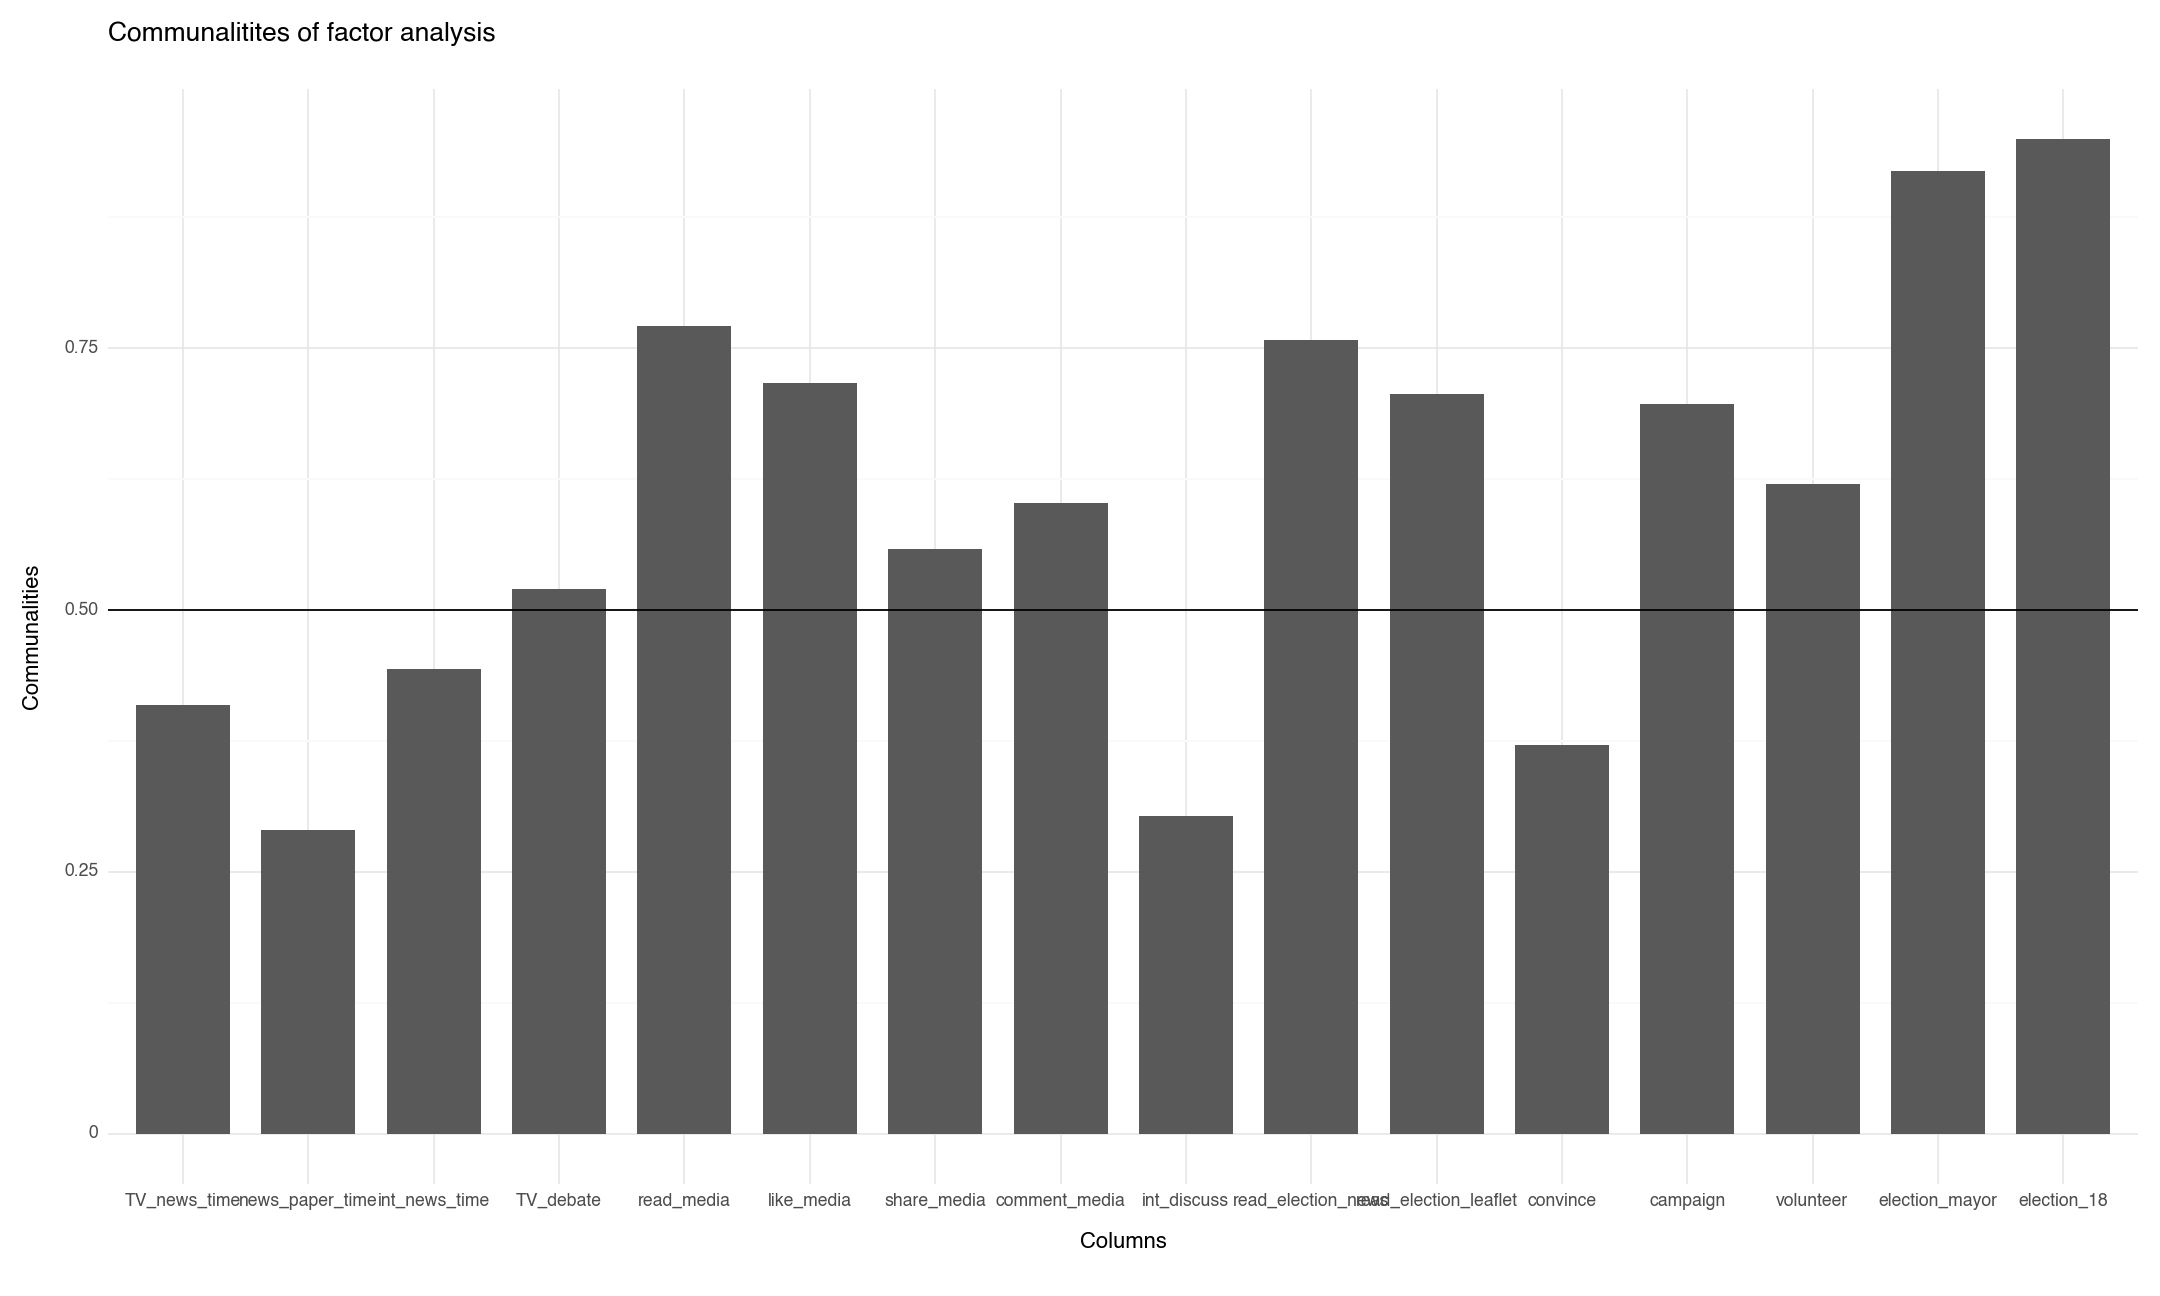

<Figure Size: (1080 x 648)>

In [ ]:
# Data viz
plotnine.options.figure_size = (15, 9)
communality_bar = (
    ggplot(data = df_communalities_DV)+
    geom_bar(aes(x = 'Column',
                 y = 'Communality'),
             width = 0.75,
             stat = 'identity')+
    geom_hline(yintercept = 0.5)+
    scale_x_discrete(limits = df_communalities_DV['Column'].tolist())+
    labs(title = 'Communalitites of factor analysis')+
    xlab('Columns')+
    ylab('Communalities')+
    theme_minimal()
)
# Display the viz
communality_bar

### Reduce Factors

In [ ]:
# Check Eigenvalues
eigenValue, value = fa.get_eigenvalues()

In [ ]:
# Convert the results into a dataframe
df_DV_eigen = pd.DataFrame({'Factor': range(1, len(eigenValue) + 1), 'Eigen value': eigenValue})
df_DV_eigen.style.apply(Factor_Analysis.highlightEigenvalue, subset = ['Eigen value'])

,Factor,Eigen value
0,1,4.251428
1,2,2.057097
2,3,1.428251
3,4,1.185024
4,5,0.982240
5,6,0.846947
6,7,0.832451
7,8,0.772555
8,9,0.682499
9,10,0.631522


According to the Kaiser criteria, the number of factors generated is 2. It means that the 16 columns or well-known variables will be grouped and interpreted into 2 factors.

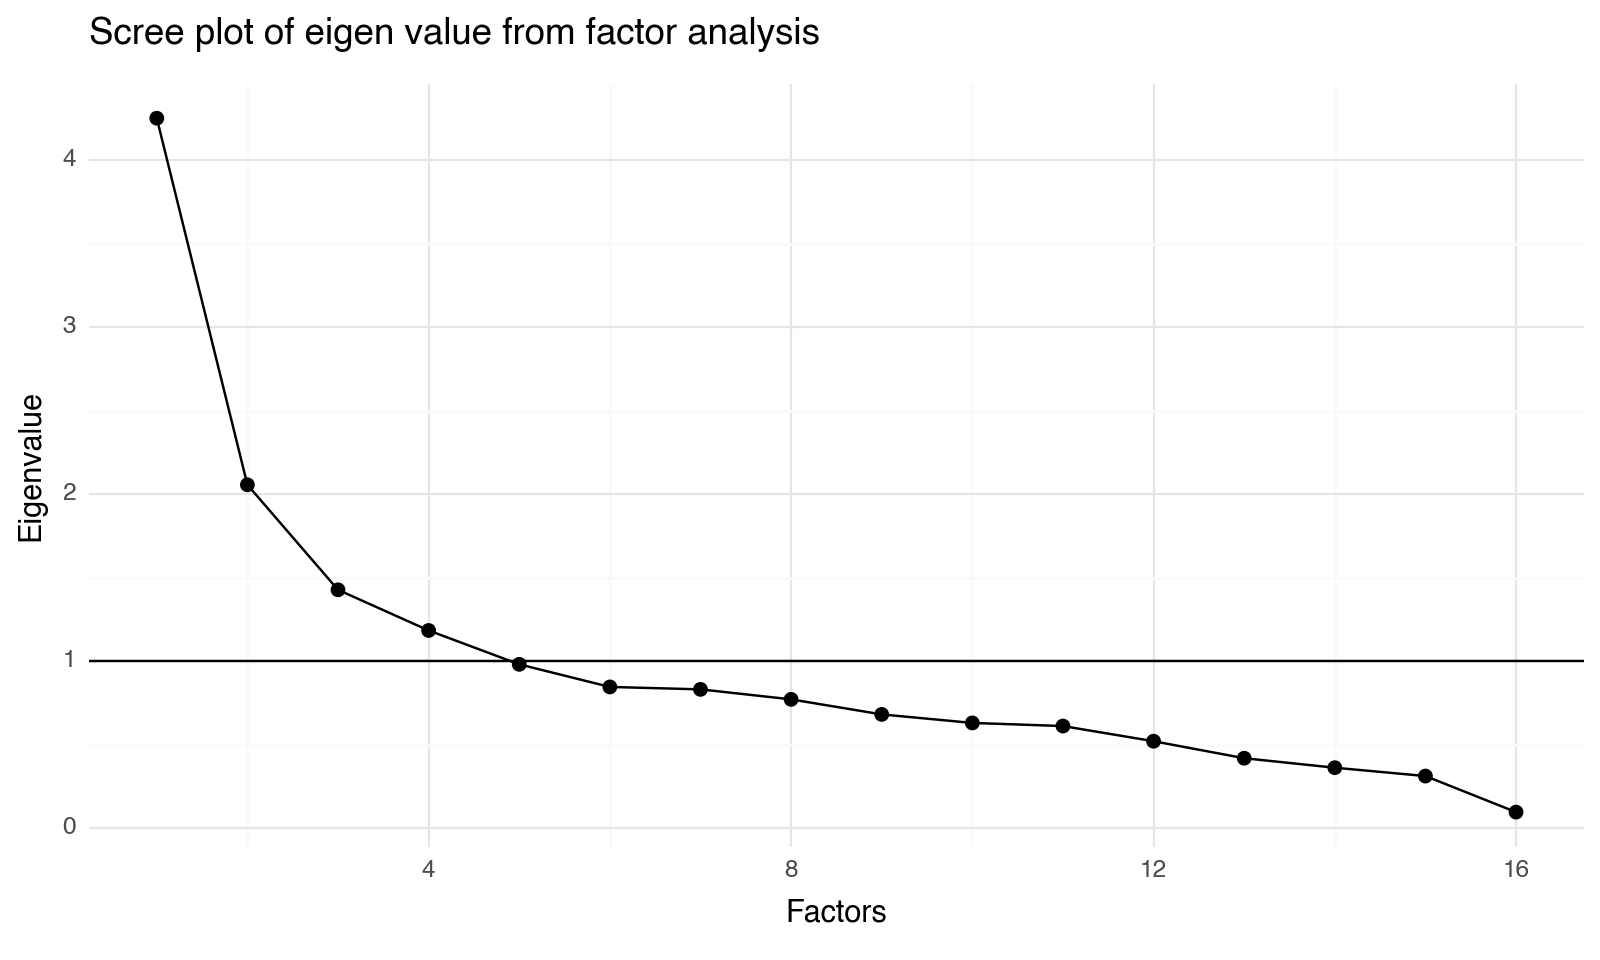

<Figure Size: (800 x 480)>

In [ ]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
DV_scree_eigenvalue = (
    ggplot(data = df_DV_eigen)+
    geom_hline(yintercept = 1)+
    geom_line(aes(x = 'Factor',
                  y = 'Eigen value'))+
    geom_point(aes(x = 'Factor',
                   y = 'Eigen value'),
               size = 2)+
    labs(title = 'Scree plot of eigen value from factor analysis')+
    xlab('Factors')+
    ylab('Eigenvalue')+
    theme_minimal()
)
# Display the viz
DV_scree_eigenvalue

In [ ]:
# Factor analysis with rotation
fa = FactorAnalyzer(n_factors = 4, rotation = 'varimax')
fa.fit(DV_df)
# Create a factor's names
facs = ['Factors' + ' ' + str(i + 1) for i in range(4)]
print(facs)
# Loading factors
pd.DataFrame(data = fa.loadings_, index = DV_df.columns, columns = facs).style.apply(Factor_Analysis.highlightLoadings)

['Factors 1', 'Factors 2', 'Factors 3', 'Factors 4']


,Factors 1,Factors 2,Factors 3,Factors 4
TV_news_time,0.249018,0.034852,0.287438,0.045294
news_paper_time,0.129048,-0.074070,0.157857,0.078601
int_news_time,0.416359,0.000136,0.296613,0.006881
TV_debate,0.208112,0.207312,0.467451,0.203049
read_media,0.598707,0.125468,0.362657,0.063921
like_media,0.629836,0.048903,0.216531,0.067014
share_media,0.600315,0.047601,-0.021777,0.136630
comment_media,0.568489,-0.022581,0.031048,0.177959
int_discuss,0.395835,0.030205,0.100321,0.007741
read_election_news,0.034269,0.359524,0.659196,0.118846


#### 由上述結果可以發現依變數可以分為4個構面：</b>

* 線上媒體政治參與(online_media_pp) : read_media / like_media / share_media / comment_media</b>

-> reference : 劉嘉薇，2019
* 投票參與(voting) : election_mayor / election_18</b>

-> reference : Barnes and  Kaase (1979) 

* 線下媒體政治參與(offline_media_pp) : read_election_news / read_election_leaflet

-> reference : 徐火炎，2001
* 競選工作式政治參與(campaign_worker_pp) : campaign / volunteer

-> reference : Mibrath and Goel，1977

In [ ]:
# Explained variance
idx = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
df_variance = pd.DataFrame(data = fa.get_factor_variance(), index = idx, columns = facs)
# Ratio of variance
ratioVariance = fa.get_factor_variance()[1] / fa.get_factor_variance()[1].sum()
df_ratio_var = pd.DataFrame(data = ratioVariance.reshape((1, 4)), index = ['Ratio Variance'], columns = facs)
# New completed dataframe
df_variance.append(df_ratio_var)

/var/folders/dn/wbyhv8k14697mm1zy19w1jh40000gn/T/ipykernel_82610/1363470732.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Factors 1,Factors 2,Factors 3,Factors 4
SS Loadings,2.186075,1.942658,1.737916,1.195815
Proportion Variance,0.136630,0.121416,0.108620,0.074738
Cumulative Variance,0.136630,0.258046,0.366666,0.441404
Ratio Variance,0.309534,0.275068,0.246078,0.169320


In [ ]:
df_factors = pd.DataFrame(data = fa.fit_transform(DV_df),columns = facs)
df_factors                     

,Factors 1,Factors 2,Factors 3,Factors 4
0,0.401327,1.090674,-1.326542,-0.408041
1,0.174039,-1.503807,0.263618,-0.413159
2,0.268508,-0.493079,-1.069408,-0.314089
3,0.614651,0.756339,0.826183,-0.460537
4,1.106974,0.230415,-0.299575,-0.609832
...,...,...,...,...
498,-0.537318,0.600628,1.502293,-0.276675
499,0.982530,0.584389,0.723440,-0.687787
500,-0.673782,-1.172304,-1.105332,-0.073598
501,-0.673782,-1.172304,-1.105332,-0.073598


### Establish Index with mean method after FAC

In [ ]:
online_media_pp_vars = ['read_media', 'like_media', 'share_media', 'comment_media']
voting_vars = ['election_mayor', 'election_18']
offline_media_pp_vars = ['read_election_news', 'read_election_leaflet']
campaign_worker_pp_vars = ['campaign', 'volunteer']

In [ ]:
# Calculate the scores for each factor
ml_df['online_media_pp_mean'] = ml_df[online_media_pp_vars].mean(axis=1)
ml_df['voting_mean'] = ml_df[voting_vars].mean(axis=1)
ml_df['offline_media_pp_mean'] = ml_df[offline_media_pp_vars].mean(axis=1)
ml_df['campaign_worker_pp_mean'] = ml_df[campaign_worker_pp_vars].mean(axis=1)

### Establish Index with Factor Scores after FAC

In [ ]:
df_factors.rename(columns = {'Factors 1': 'online_media_pp', 
                             'Factors 2': 'voting',
                             'Factors 3': 'offline_media_pp',
                             'Factors 4': 'campaign_worker_pp'}, inplace = True)
ml_df = ml_df.join(df_factors)

In [ ]:
ml_df

,TV_news_time,news_paper_time,int_news_time,TV_debate,read_media,like_media,share_media,comment_media,int_discuss,read_election_news,...,Negative_2,Negative_3,online_media_pp_mean,voting_mean,offline_media_pp_mean,campaign_worker_pp_mean,online_media_pp,voting,offline_media_pp,campaign_worker_pp
0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,...,轉而支持其他候選人,轉而支持其他候選人,1.75,4.0,1.0,1.0,0.401327,1.090674,-1.326542,-0.408041
1,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,2.0,2.0,...,沒有影響,沒有影響,1.75,1.0,2.5,1.0,0.174039,-1.503807,0.263618,-0.413159
2,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,...,轉而支持其他候選人,轉而支持其他候選人,1.50,2.0,1.0,1.0,0.268508,-0.493079,-1.069408,-0.314089
3,1.0,1.0,1.0,3.0,4.0,2.0,1.0,1.0,2.0,4.0,...,沒有影響,轉而支持其他候選人,2.00,4.0,3.5,1.0,0.614651,0.756339,0.826183,-0.460537
4,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0,2.0,...,轉而支持其他候選人,沒有影響,2.00,3.0,2.5,1.0,1.106974,0.230415,-0.299575,-0.609832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,...,沒有影響,沒有影響,1.00,4.0,4.0,1.0,-0.537318,0.600628,1.502293,-0.276675
499,2.0,1.0,3.0,2.0,3.0,3.0,1.0,1.0,2.0,3.0,...,沒有影響,沒有影響,2.00,4.0,3.0,1.0,0.982530,0.584389,0.723440,-0.687787
500,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,轉而支持其他候選人,可能因此不去投票,1.00,1.0,1.0,1.0,-0.673782,-1.172304,-1.105332,-0.073598
501,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,轉而支持其他候選人,轉而支持其他候選人,1.00,1.0,1.0,1.0,-0.673782,-1.172304,-1.105332,-0.073598


### Establish Index with Total Scores : goruping to offlinepp and onlinepp before FAC
Total_Scores = (factor1_value * factor1_Proportion + factor2_value * factor2_Proportion) / Cumulative Variance

In [ ]:
online_pp_vars = ['TV_news_time', 'news_paper_time', 'int_news_time', 'TV_debate', 'read_media', 'like_media', 'share_media', 'comment_media', 'int_discuss']
offline_pp_vars = ['read_election_news', 'read_election_leaflet', 'convince', 'campaign', 'volunteer', 'election_mayor', 'election_18']
online_pp_df = ml_df[online_pp_vars]
offline_pp_df = ml_df[offline_pp_vars]

#### Online PP

In [ ]:
print('-' * 20 + " offlnie_pp " + '-' * 20)
print('\n')
print("* Bartlett's test")
chiSquareValue, pValue = calculate_bartlett_sphericity(online_pp_df)
print('Chi-square value : {}'.format(round(chiSquareValue, ndigits = 3)))
print('p-value          : {}'.format(round(pValue, ndigits = 3)))
print('\n')
print('* Kaiser-Meyer-Olkin')
KMO, KMO_model = calculate_kmo(online_pp_df)
print('KMO value : {}'.format(round(KMO_model, ndigits = 3)))

-------------------- offlnie_pp --------------------


* Bartlett's test
Chi-square value : 784.803
p-value          : 0.0


* Kaiser-Meyer-Olkin
KMO value : 0.77


The Bartlett test produces a p-value that is less than 0.05. It means, we reject the null hypothesis or in this case, at least two population variances are different.

In [ ]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 25, rotation = None)
fa.fit(online_pp_df)
# The communalities
df_communalities_online_pp = pd.DataFrame(data = {'Column': online_pp_df.columns, 'Communality': fa.get_communalities()})
df_communalities_online_pp
df_communalities_online_pp.style.apply(Factor_Analysis.highlightCommunalities, subset = ['Communality'])

,Column,Communality
0,TV_news_time,0.414622
1,news_paper_time,0.238235
2,int_news_time,0.449395
3,TV_debate,0.369029
4,read_media,0.777808
5,like_media,0.693477
6,share_media,0.502956
7,comment_media,0.605432
8,int_discuss,0.211261


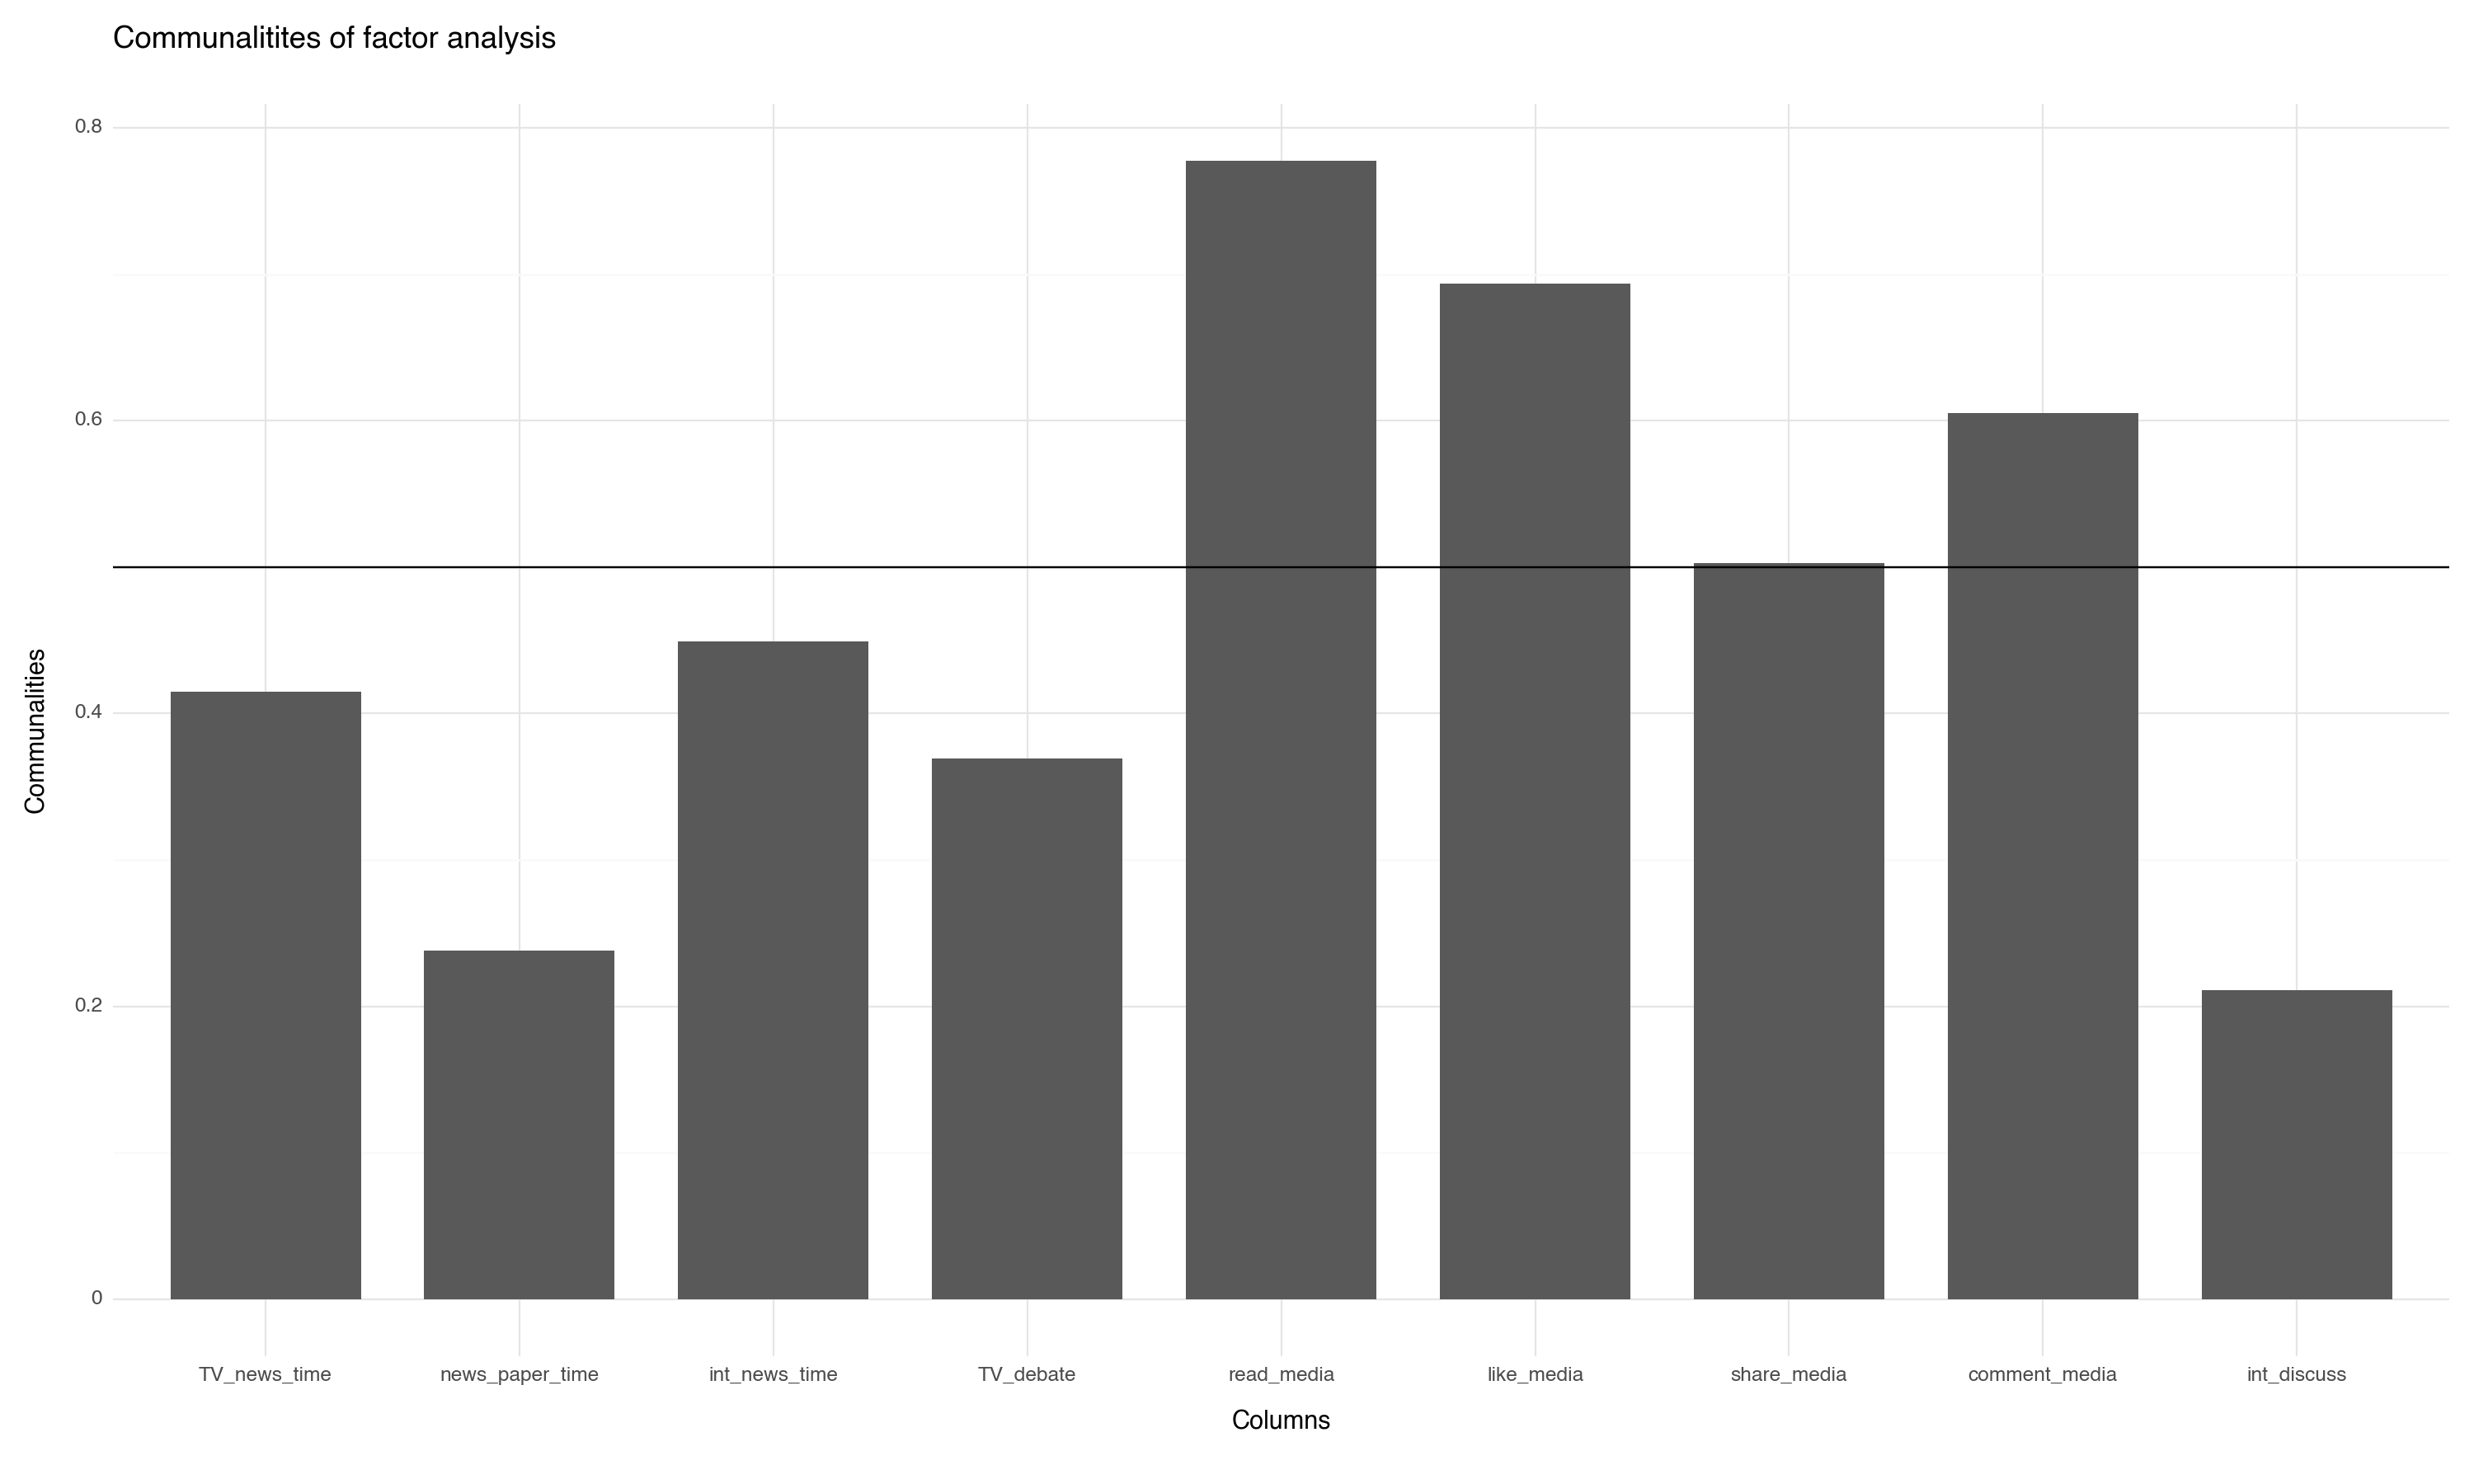

<Figure Size: (1500 x 900)>

In [ ]:
# Data viz
plotnine.options.figure_size = (15, 9)
communality_bar = (
    ggplot(data = df_communalities_online_pp)+
    geom_bar(aes(x = 'Column',
                 y = 'Communality'),
             width = 0.75,
             stat = 'identity')+
    geom_hline(yintercept = 0.5)+
    scale_x_discrete(limits = df_communalities_online_pp['Column'].tolist())+
    labs(title = 'Communalitites of factor analysis')+
    xlab('Columns')+
    ylab('Communalities')+
    theme_minimal()
)
# Display the viz
communality_bar

In [ ]:
# Check Eigenvalues
eigenValue, value = fa.get_eigenvalues()

In [ ]:
# Convert the results into a dataframe
df_online_eigen = pd.DataFrame({'Factor': range(1, len(eigenValue) + 1), 'Eigen value': eigenValue})
df_online_eigen.style.apply(Factor_Analysis.highlightEigenvalue, subset = ['Eigen value'])

,Factor,Eigen value
0,1,2.934852
1,2,1.135618
2,3,1.068118
3,4,0.836136
4,5,0.791042
5,6,0.664594
6,7,0.640115
7,8,0.561833
8,9,0.367692


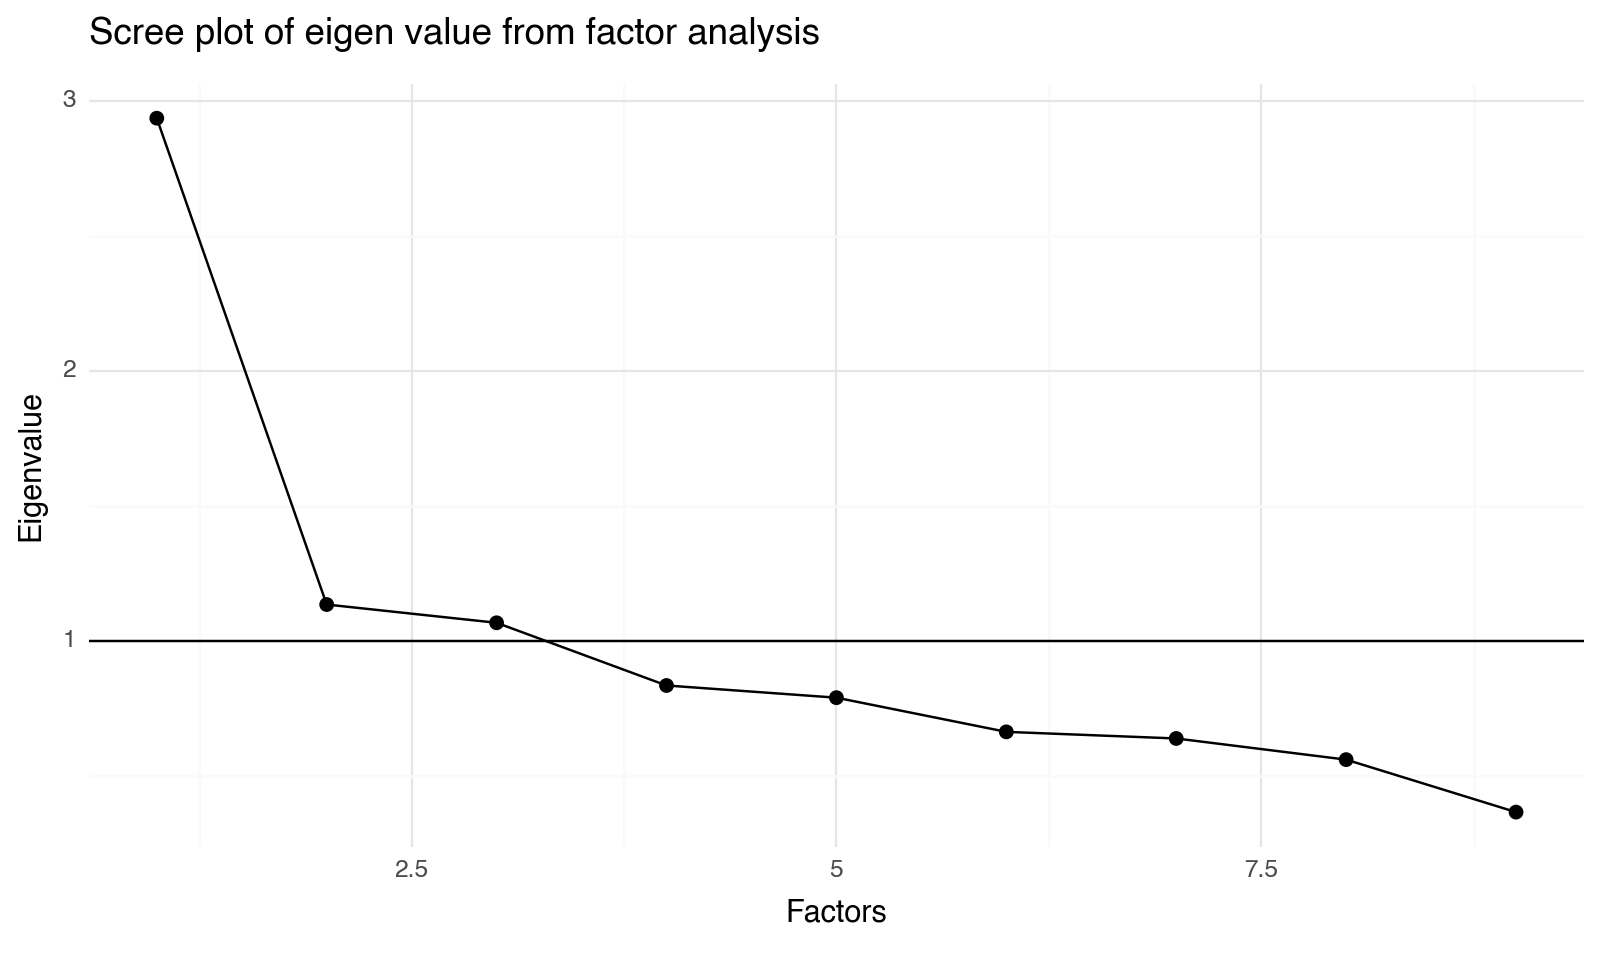

<Figure Size: (800 x 480)>

In [ ]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
online_scree_eigenvalue = (
    ggplot(data = df_online_eigen)+
    geom_hline(yintercept = 1)+
    geom_line(aes(x = 'Factor',
                  y = 'Eigen value'))+
    geom_point(aes(x = 'Factor',
                   y = 'Eigen value'),
               size = 2)+
    labs(title = 'Scree plot of eigen value from factor analysis')+
    xlab('Factors')+
    ylab('Eigenvalue')+
    theme_minimal()
)
# Display the viz
online_scree_eigenvalue

In [ ]:
# Factor analysis with rotation
fa = FactorAnalyzer(n_factors = 3, rotation = 'varimax')
fa.fit(online_pp_df)
# Create a factor's names
facs = ['Factors' + ' ' + str(i + 1) for i in range(3)]
print(facs)
# Loading factors
pd.DataFrame(data = fa.loadings_, index = online_pp_df.columns, columns = facs).style.apply(Factor_Analysis.highlightLoadings)

['Factors 1', 'Factors 2', 'Factors 3']


,Factors 1,Factors 2,Factors 3
TV_news_time,0.263118,0.070958,0.434839
news_paper_time,-0.012978,0.102923,0.405417
int_news_time,0.384558,0.177302,0.419706
TV_debate,0.428353,0.068104,0.168913
read_media,0.798005,0.272922,0.076706
like_media,0.534038,0.479717,0.008996
share_media,0.133200,0.610286,0.148361
comment_media,0.128193,0.668791,0.145699
int_discuss,0.230473,0.299298,0.119721


In [ ]:
# Explained variance
idx = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
df_variance = pd.DataFrame(data = fa.get_factor_variance(), index = idx, columns = facs)
# Ratio of variance
ratioVariance = fa.get_factor_variance()[1] / fa.get_factor_variance()[1].sum()
df_ratio_var = pd.DataFrame(data = ratioVariance.reshape((1, 3)), index = ['Ratio Variance'], columns = facs)
# New completed dataframe
df_variance.append(df_ratio_var)

/var/folders/dn/wbyhv8k14697mm1zy19w1jh40000gn/T/ipykernel_82610/3722499014.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Factors 1,Factors 2,Factors 3
SS Loadings,1.410073,1.265628,0.621669
Proportion Variance,0.156675,0.140625,0.069074
Cumulative Variance,0.156675,0.297300,0.366374
Ratio Variance,0.427636,0.383829,0.188535


In [ ]:
df_factors_onlnie = pd.DataFrame(data = fa.fit_transform(online_pp_df),columns = facs)
df_factors_onlnie                     

,Factors 1,Factors 2,Factors 3
0,0.722378,-0.076201,-0.630175
1,0.151671,0.265266,-0.677950
2,0.495475,-0.358419,-0.434383
3,1.761728,-0.264966,-0.617789
4,0.435594,0.918510,-0.445414
...,...,...,...
498,-0.973771,-0.225250,2.159402
499,1.426749,-0.047664,0.693567
500,-1.118462,-0.356609,-0.184334
501,-1.118462,-0.356609,-0.184334


In [ ]:
ml_df['onlnie_scores'] = (df_factors_onlnie['Factors 1'] * fa.get_factor_variance()[1][0] + df_factors_onlnie['Factors 2'] * fa.get_factor_variance()[1][1] + df_factors_onlnie['Factors 3'] * fa.get_factor_variance()[1][2]) / fa.get_factor_variance()[1].sum()

#### Offline PP

In [ ]:
print('-' * 20 + " offlnie_pp " + '-' * 20)
print('\n')
print("* Bartlett's test")
chiSquareValue, pValue = calculate_bartlett_sphericity(offline_pp_df)
print('Chi-square value : {}'.format(round(chiSquareValue, ndigits = 3)))
print('p-value          : {}'.format(round(pValue, ndigits = 3)))
print('\n')
print('* Kaiser-Meyer-Olkin')
KMO, KMO_model = calculate_kmo(offline_pp_df)
print('KMO value : {}'.format(round(KMO_model, ndigits = 3)))

-------------------- offlnie_pp --------------------


* Bartlett's test
Chi-square value : 1495.95
p-value          : 0.0


* Kaiser-Meyer-Olkin
KMO value : 0.64


In [ ]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 25, rotation = None)
fa.fit(offline_pp_df)
# The communalities
df_communalities_offline_pp = pd.DataFrame(data = {'Column': offline_pp_df.columns, 'Communality': fa.get_communalities()})
df_communalities_offline_pp
df_communalities_offline_pp.style.apply(Factor_Analysis.highlightCommunalities, subset = ['Communality'])

,Column,Communality
0,read_election_news,0.726516
1,read_election_leaflet,0.690885
2,convince,0.237935
3,campaign,0.646440
4,volunteer,0.601955
5,election_mayor,0.904081
6,election_18,0.908956


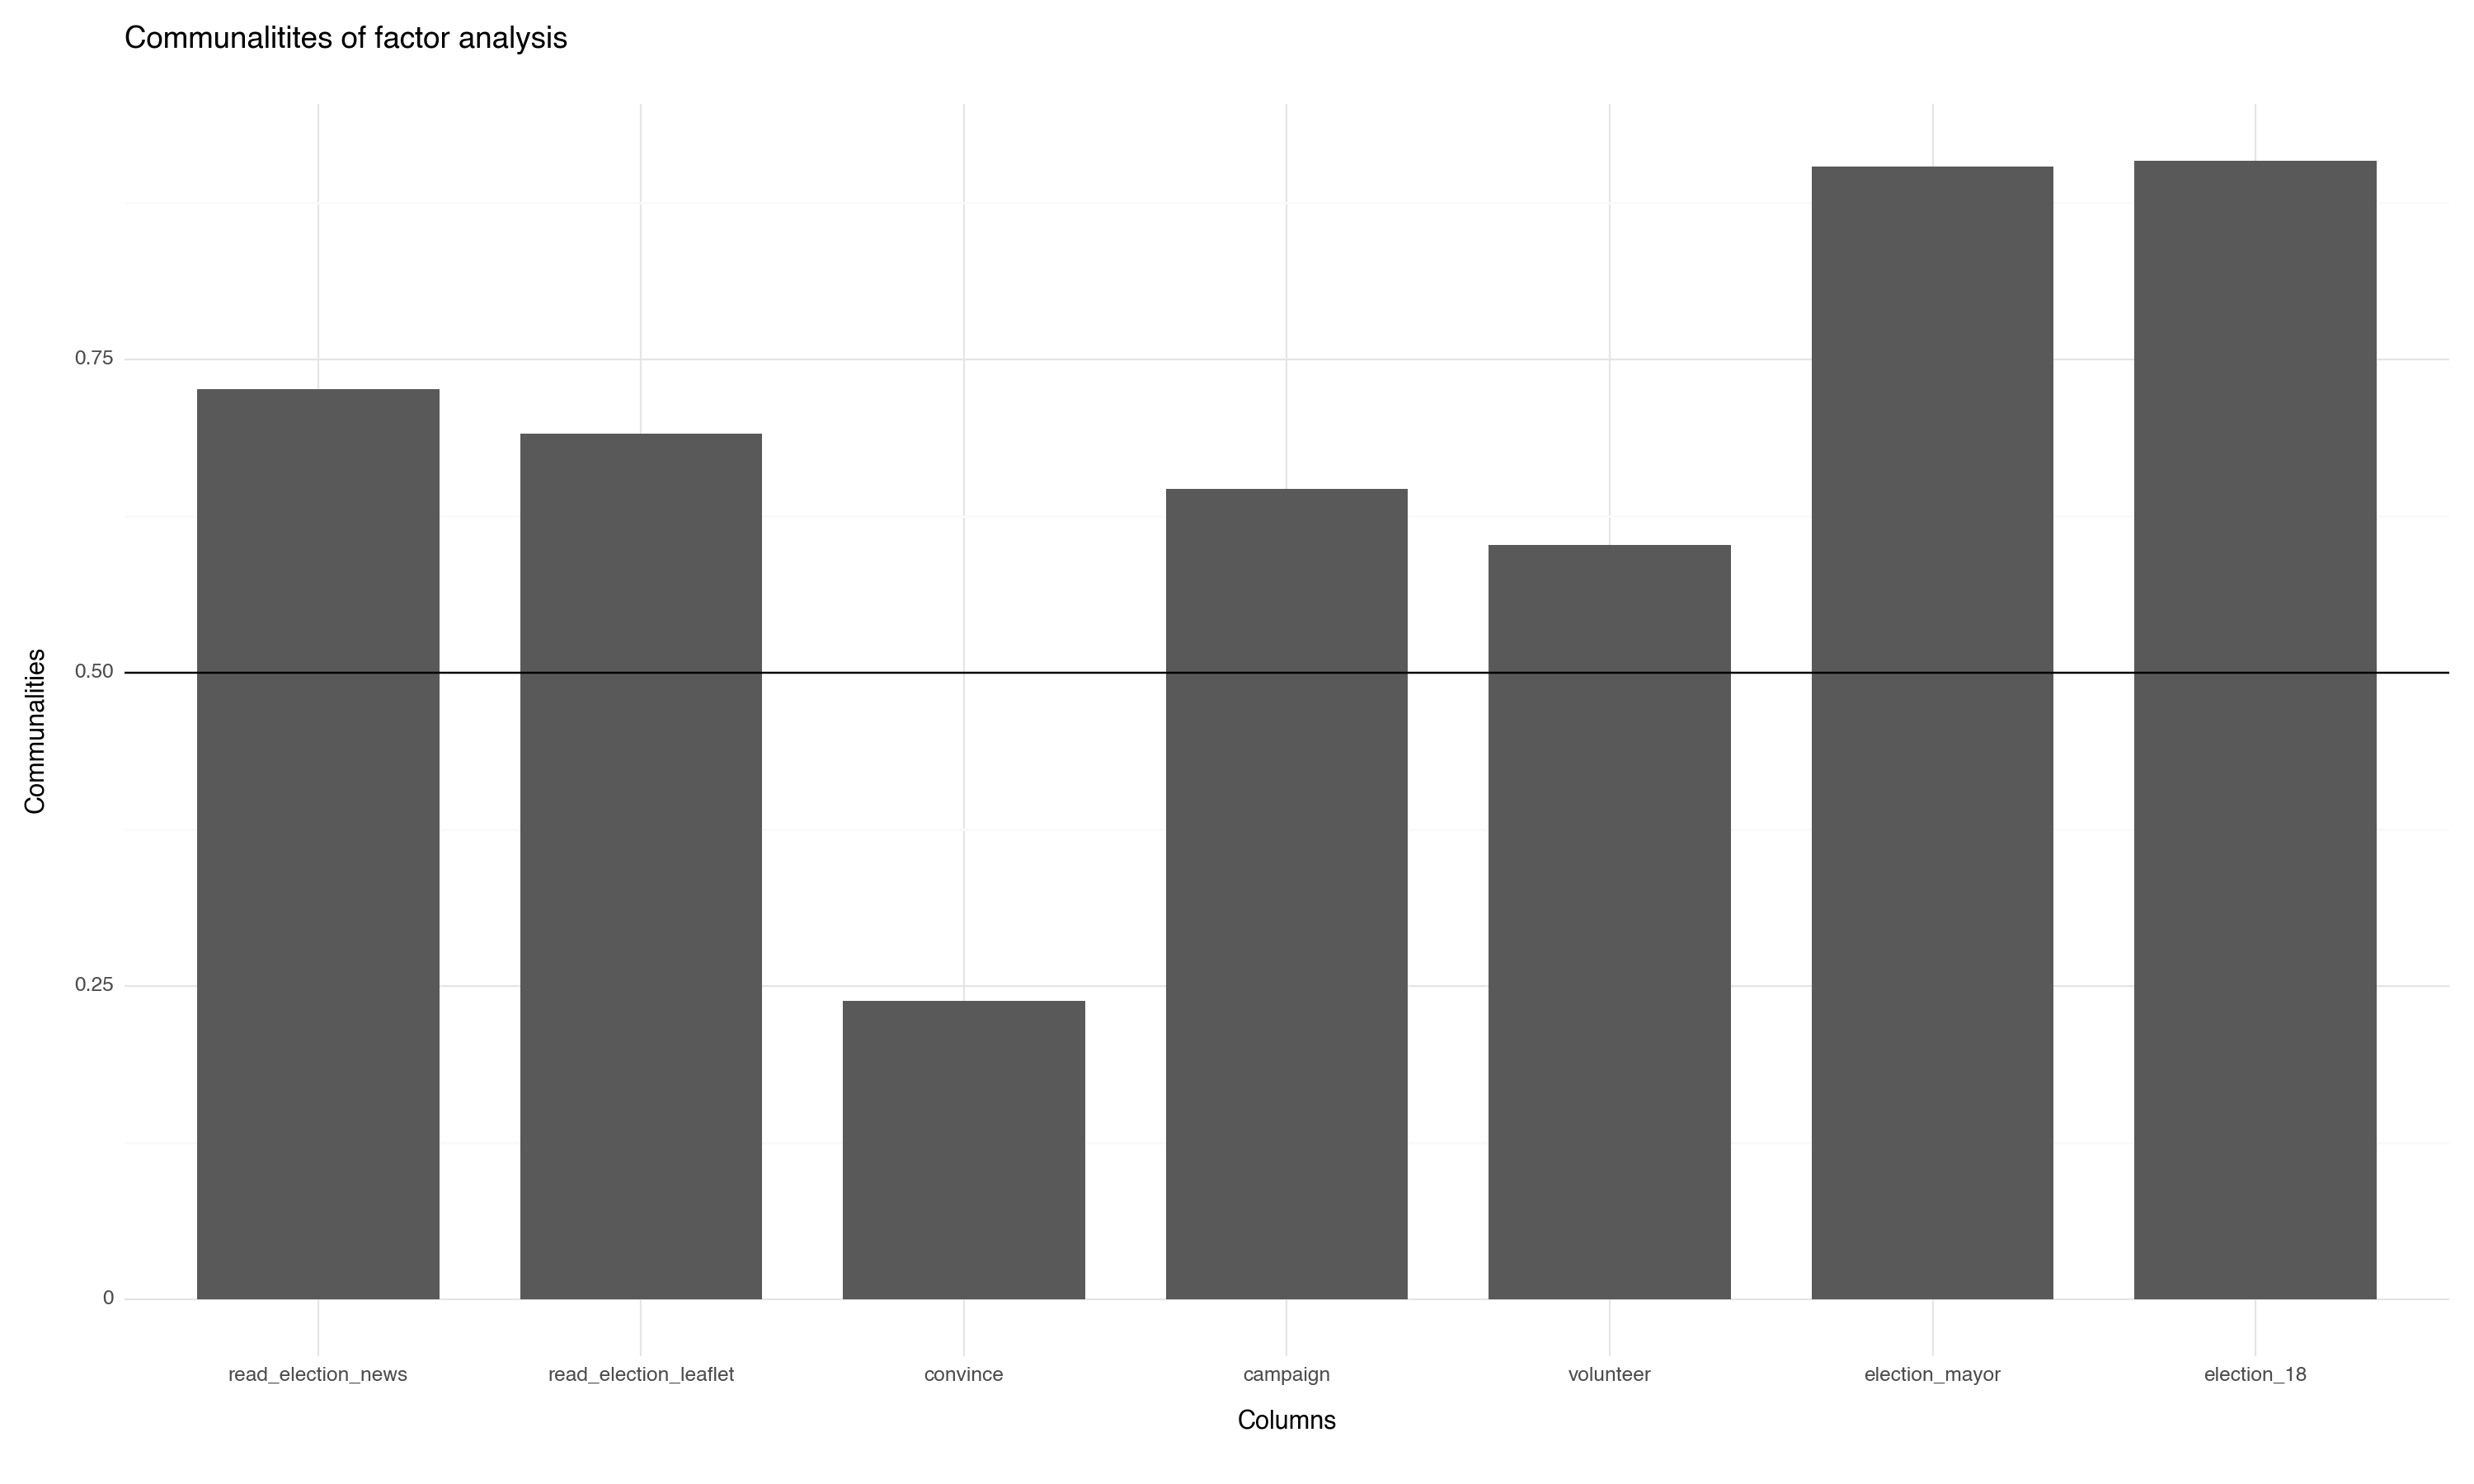

<Figure Size: (1500 x 900)>

In [ ]:
# Data viz
plotnine.options.figure_size = (15, 9)
communality_bar = (
    ggplot(data = df_communalities_offline_pp)+
    geom_bar(aes(x = 'Column',
                 y = 'Communality'),
             width = 0.75,
             stat = 'identity')+
    geom_hline(yintercept = 0.5)+
    scale_x_discrete(limits = df_communalities_offline_pp['Column'].tolist())+
    labs(title = 'Communalitites of factor analysis')+
    xlab('Columns')+
    ylab('Communalities')+
    theme_minimal()
)
# Display the viz
communality_bar

In [ ]:
# Check Eigenvalues
eigenValue, value = fa.get_eigenvalues()

In [ ]:
# Convert the results into a dataframe
df_offline_eigen = pd.DataFrame({'Factor': range(1, len(eigenValue) + 1), 'Eigen value': eigenValue})
df_offline_eigen.style.apply(Factor_Analysis.highlightEigenvalue, subset = ['Eigen value'])

,Factor,Eigen value
0,1,2.786724
1,2,1.570308
2,3,0.945140
3,4,0.830727
4,5,0.427812
5,6,0.339374
6,7,0.099915


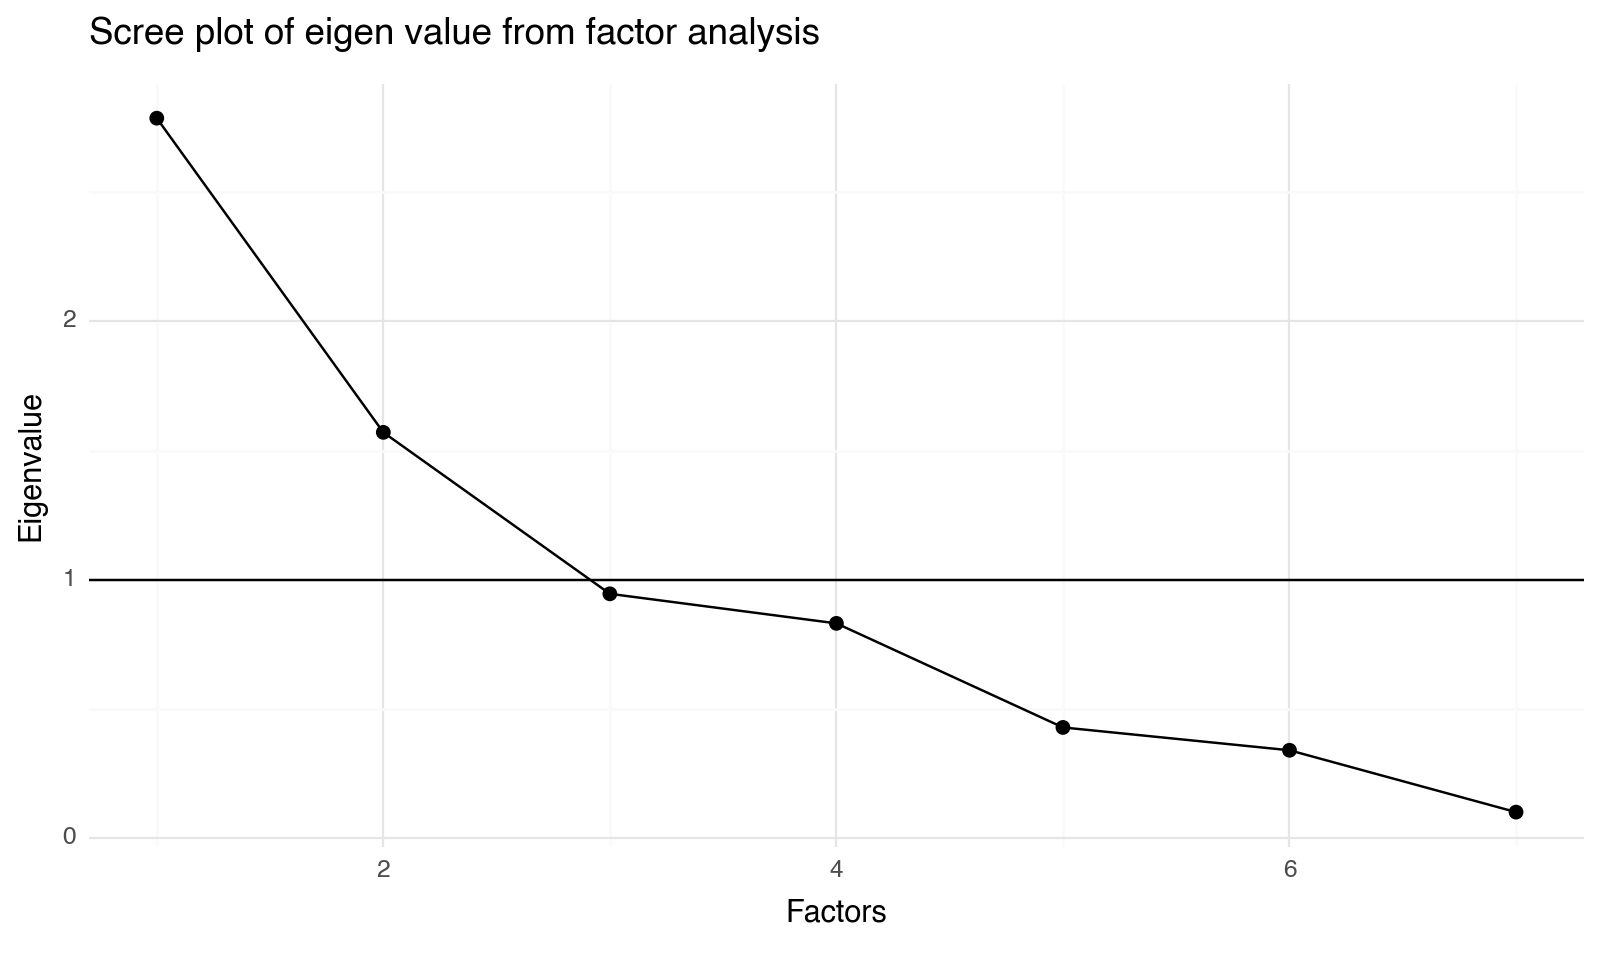

<Figure Size: (800 x 480)>

In [ ]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
offline_scree_eigenvalue = (
    ggplot(data = df_offline_eigen)+
    geom_hline(yintercept = 1)+
    geom_line(aes(x = 'Factor',
                  y = 'Eigen value'))+
    geom_point(aes(x = 'Factor',
                   y = 'Eigen value'),
               size = 2)+
    labs(title = 'Scree plot of eigen value from factor analysis')+
    xlab('Factors')+
    ylab('Eigenvalue')+
    theme_minimal()
)
# Display the viz
offline_scree_eigenvalue

In [ ]:
# Factor analysis with rotation
fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax')
fa.fit(offline_pp_df)
# Create a factor's names
facs = ['Factors' + ' ' + str(i + 1) for i in range(2)]
print(facs)
# Loading factors
pd.DataFrame(data = fa.loadings_, index = offline_pp_df.columns, columns = facs).style.apply(Factor_Analysis.highlightLoadings)

['Factors 1', 'Factors 2']


,Factors 1,Factors 2
read_election_news,0.621619,0.240353
read_election_leaflet,0.535222,0.258769
convince,0.238827,0.143331
campaign,0.081556,0.694075
volunteer,0.067147,0.737542
election_mayor,0.896737,-0.060803
election_18,0.896609,-0.116633


In [ ]:
# Explained variance
idx = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
df_variance = pd.DataFrame(data = fa.get_factor_variance(), index = idx, columns = facs)
# Ratio of variance
ratioVariance = fa.get_factor_variance()[1] / fa.get_factor_variance()[1].sum()
df_ratio_var = pd.DataFrame(data = ratioVariance.reshape((1, 2)), index = ['Ratio Variance'], columns = facs)
# New completed dataframe
df_variance.append(df_ratio_var)

/var/folders/dn/wbyhv8k14697mm1zy19w1jh40000gn/T/ipykernel_82610/2648890745.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Factors 1,Factors 2
SS Loadings,2.349115,1.188282
Proportion Variance,0.335588,0.169755
Cumulative Variance,0.335588,0.505343
Ratio Variance,0.664080,0.335920


In [ ]:
df_factors_offlnie = pd.DataFrame(data = fa.fit_transform(offline_pp_df),columns = facs)
df_factors_offlnie                     

,Factors 1,Factors 2
0,0.333988,-0.823392
1,-1.166190,0.052735
2,-0.888512,-0.374432
3,1.053984,-0.124877
4,0.154959,-0.364895
...,...,...
498,1.110757,-0.175752
499,0.887584,-0.316267
500,-1.553387,-0.263000
501,-1.553387,-0.263000


In [ ]:
ml_df['offlnie_scores'] = (df_factors_offlnie['Factors 1'] * fa.get_factor_variance()[1][0] + df_factors_offlnie['Factors 2'] * fa.get_factor_variance()[1][1]) / fa.get_factor_variance()[1].sum()